In [2]:
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import seaborn                 as sns
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
from folium import Marker
import statsmodels.formula.api as smf
import statsmodels.api         as sm
import scipy

### EDA

Lets star by loading the data set we scraped before.

In [3]:
df=pd.read_csv('zillow_listing_phx.csv')  
df

,prices,address,beds,zipcode,lat,long,url,baths,sq_feet
0,254900.0,15818 N 25th St UNIT 112 Phoenix AZ 85032,3,85032,33.629870,-112.028788,https://www.zillow.com/homedetails/15818-N-25t...,3,1275
1,254900.0,3848 N 3rd Ave UNIT 1030 Phoenix AZ 85013,2,85013,33.493887,-112.080620,https://www.zillow.com/homedetails/3848-N-3rd-...,2,989
2,384900.0,522 E Marco Polo Rd Phoenix AZ 85024,3,85024,33.666465,-112.066867,https://www.zillow.com/homedetails/522-E-Marco...,3,1348
3,533100.0,16653 S 24th Pl Phoenix AZ 85048,4,85048,33.294945,-112.031217,https://www.zillow.com/homedetails/16653-S-24t...,3,2197
4,364900.0,2418 E Chipman Rd Phoenix AZ 85040,3,85040,33.402602,-112.029109,https://www.zillow.com/homedetails/2418-E-Chip...,2,1338
...,...,...,...,...,...,...,...,...,...
225,364900.0,2418 E Chipman Rd Phoenix AZ 85040,3,85040,33.402602,-112.029109,https://www.zillow.com/homedetails/2418-E-Chip...,2,1338
226,322100.0,10411 N 9th St UNIT 1 Phoenix AZ 85020,2,85020,33.580618,-112.060193,https://www.zillow.com/homedetails/10411-N-9th...,2,976
227,354900.0,1327 W Wahalla Ln Phoenix AZ 85027,2,85027,33.667171,-112.088014,https://www.zillow.com/homedetails/1327-W-Waha...,2,1091
228,243100.0,2929 W Yorkshire Dr UNIT 1041 Phoenix AZ 85027,2,85027,33.662520,-112.122142,https://www.zillow.com/homedetails/2929-W-York...,2,1019


<AxesSubplot:xlabel='sq_feet', ylabel='Count'>

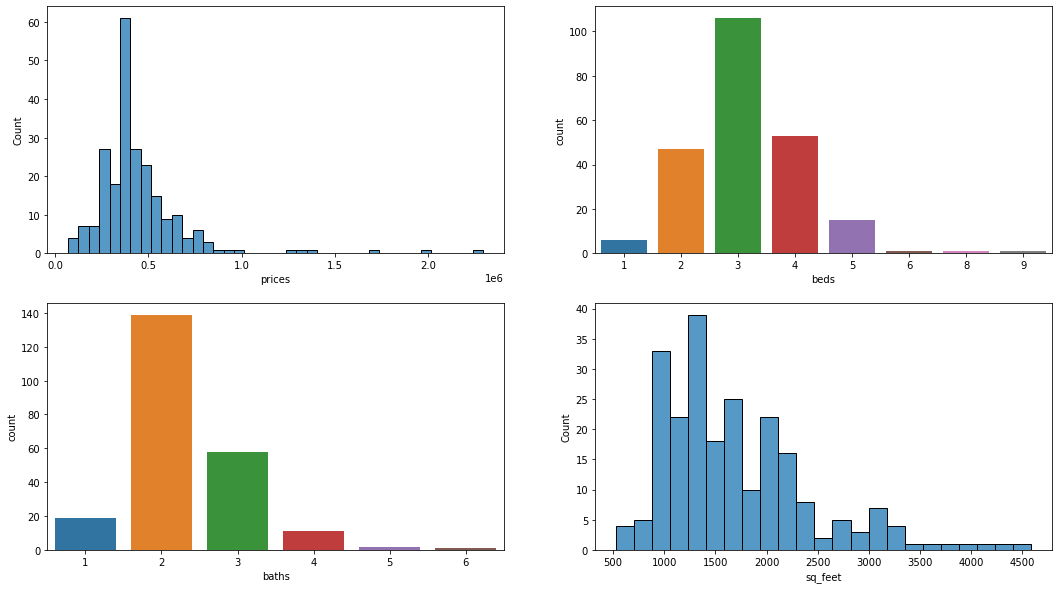

In [4]:
plt.figure(figsize=(18,10))
# sns.histplot(data=penguins, x="flipper_length_mm")

plt.subplot(2,2,1)
sns.histplot(data=df, x="prices")
plt.subplot(2,2,2)
sns.countplot(data=df, x="beds")
plt.subplot(2,2,3)
sns.countplot(data=df, x="baths")
plt.subplot(2,2,4)
sns.histplot(data=df, x="sq_feet", bins=23)

##  Geo analysis.
We would like to see how much the price of a house in phoenix depends on the area. 

#### (not need it anymore, but will leave for future reference) In order to do that, we need to transform adresses to geo localizations.

In [47]:
# Create a map
phoenix_down_town=[33.469223, -112.073591]
m = folium.Map(location=phoenix_down_town, tiles='openstreetmap')

# Add points to the map
for idx, row in df.iterrows():
    Marker([row['lat'], row['long']], popup=row['prices']).add_to(m)

# Display the map
m

## Back to phoenix
Now let us get back to phoenix

Lets check how much it changes the price per square foot

<AxesSubplot:xlabel='price_per_sqfoot', ylabel='Count'>

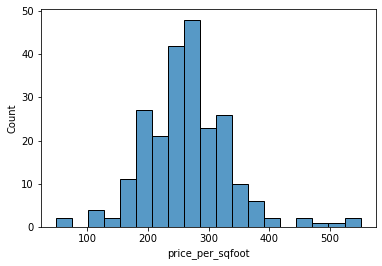

In [8]:
df['price_per_sqfoot']=df['prices']/df['sq_feet']
sns.histplot(data=df, x="price_per_sqfoot")

In [6]:
# There are several rows with not coordinates information.
# When considering coordinates we are going to ignore those rows:
df_lat_long=df[df['lat']!=0.0]

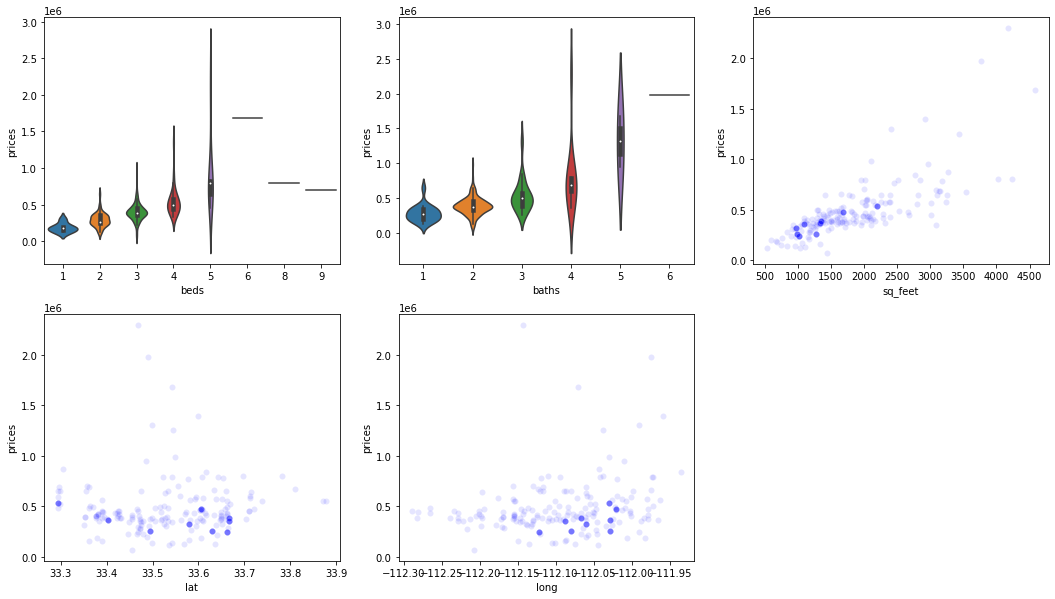

In [7]:
varstolook = ["beds", "baths", "sq_feet", "lat", "long"]

plt.figure(figsize=(18,10))
for i,var in enumerate(varstolook):
    plt.subplot(2,3,i+1)
    if var in ["beds", "baths"]:
        sns.violinplot(x=var, y='prices', data=df)
    else:
        sns.scatterplot(x=var,y='prices',data=df_lat_long, alpha=0.10,color='b')

We can see that house with 6 baths or more than 6 rooms are quite special, so we are gonna take them out from our data:

In [8]:
df=df[(df['beds']<7) & (df['baths']<6)]

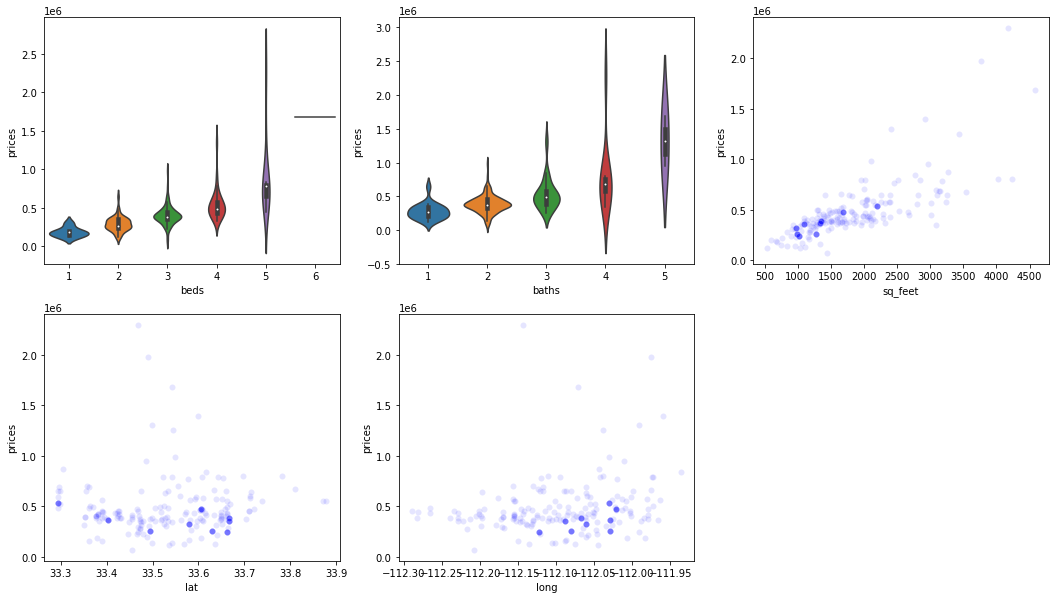

In [9]:
varstolook = ["beds", "baths", "sq_feet", "lat", "long"]

plt.figure(figsize=(18,10))
for i,var in enumerate(varstolook):
    plt.subplot(2,3,i+1)
    if var in ["beds", "baths"]:
        sns.violinplot(x=var, y='prices', data=df)
    else:
        sns.scatterplot(x=var,y='prices',data=df_lat_long, alpha=0.10,color='b')

# Linear Model

In [33]:
model_lin = smf.ols(formula = "prices ~ beds + baths+ sq_feet", 
                 data = df).fit()
model_lin.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 prices   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     105.3
Date:                Tue, 23 Nov 2021   Prob (F-statistic):           1.72e-42
Time:                        14:15:06   Log-Likelihood:                -3033.1
No. Observations:                 227   AIC:                             6074.
Df Residuals:                     223   BIC:                             6088.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.846e+04   4.28e+04      0.432      0.667   -6.58e+04    1.03e+05
beds        2025.9510   1.99e+04      0.102      0.919   -3.72e+04    4.13e+04
baths      -2.221e+04   2.13e+04     -1.041      0.299   -6.43e+04    1.98e+04
sq_feet      278.0375     30.287      9.180      0.000     218.352     337.723
==============================================================================
Omnibus:                      170.614   Durbin-Watson:                   2.146
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3295.531
Skew:                           2.652   Prob(JB):                         0.00
Kurtosis:                      20.897   Cond. No.                     8.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

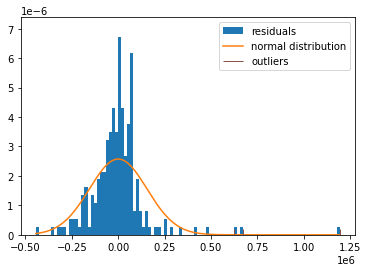

In [37]:
plt.hist(model_lin.resid, 
    density=True,     # the histogram integrates to 1 
                      # (so it can be compared to the normal distribution)
    bins=100,         #  draw a histogram with 100 bins of equal width
    label="residuals" # label for legend
    )
# now plot the normal distribution for comparison
xx = np.linspace(model_lin.resid.min(), model_lin.resid.max(), num=1000)
plt.plot(xx, scipy.stats.norm.pdf(xx, loc=0.0, scale=np.sqrt(model_lin.scale)),
    label="normal distribution")
outliers = np.abs(model_lin.resid)>4*np.sqrt(model_lin.scale)
sns.rugplot(model_lin.resid[outliers],
            color="C5", # otherwise the rugplot has the same color as the histogram
            label="outliers")
plt.legend(loc="upper right");

Shockingly, the only statistical significant coefficient is the one correspodnig to sq_feet. Let try doing some coordinate transformations to see if we can improve the model. 

In [10]:
model_log = smf.ols(formula = "np.log(prices) ~ beds + baths+  sq_feet", 
                 data = df).fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.log(prices)   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     106.1
Date:                Wed, 24 Nov 2021   Prob (F-statistic):           1.08e-42
Time:                        12:36:36   Log-Likelihood:                -42.662
No. Observations:                 227   AIC:                             93.32
Df Residuals:                     223   BIC:                             107.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.9789      0.081    147.368      0.000      11.819      12.139
beds           0.1010      0.038      2.668      0.008       0.026       0.176
baths         -0.0537      0.041     -1.324      0.187      -0.134       0.026
sq_feet        0.0004   5.75e-05      7.446      0.000       0.000       0.001
==============================================================================
Omnibus:                       88.788   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              486.771
Skew:                          -1.431   Prob(JB):                    1.99e-106
Kurtosis:                       9.579   Cond. No.                     8.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The Skew is less than zero and the Kutorsis is around one, so we can trust this linear model. We are however not out of the woods yet, because the baths does not appear to have enogh statistical significance.

Lets check how far are the residuals from normalcy:

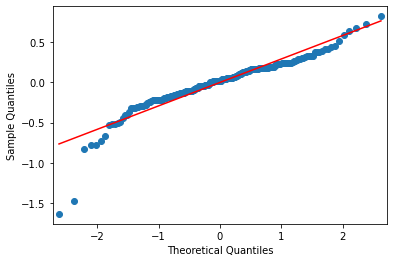

In [11]:
sm.qqplot(model_log.resid, line="s");

We can see two outliers in the bottom left, that we will proceed to identify

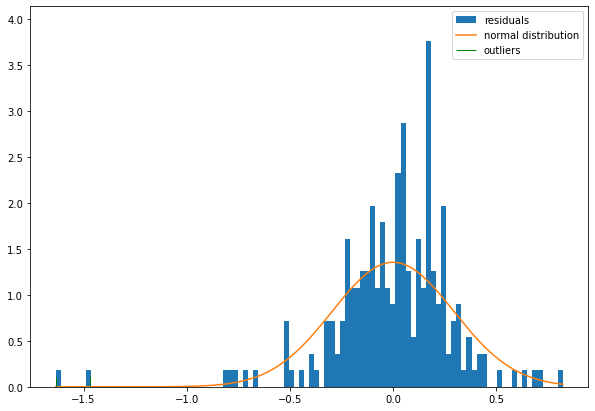

In [12]:
plt.figure(figsize=(10,7))
plt.hist(model_log.resid, 
    density=True,     # the histogram integrates to 1 
                      # (so it can be compared to the normal distribution)
    bins=100,         #  draw a histogram with 100 bins of equal width
    label="residuals" # label for legend
    )
# now plot the normal distribution for comparison
xx = np.linspace(model_log.resid.min(), model_log.resid.max(), num=1000)
plt.plot(xx, scipy.stats.norm.pdf(xx, loc=0.0, scale=np.sqrt(model_log.scale)),
    label="normal distribution")
outliers = np.abs(model_log.resid)>4*np.sqrt(model_log.scale)
sns.rugplot(model_log.resid[outliers],
            color="green", # otherwise the rugplot has the same color as the histogram
            label="outliers")
plt.legend(loc="upper right");

The residuals are not too far from normal, and there are not prominent outliers.

Text(0, 0.5, 'residuals')

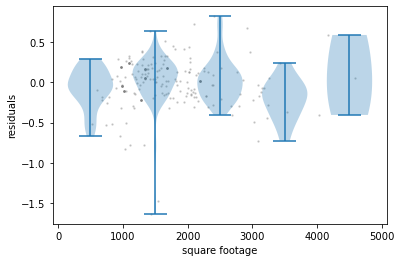

In [13]:
# scatter plot of the residuals:
plt.scatter(df['sq_feet'], model_log.resid, s=2, alpha=0.3, color="grey")
# violin plot of the same data, divided into 5 bins:
bins = np.array([0, 1000, 2000, 3000, 4000])
sqft_bin = np.digitize(df['sq_feet'], bins)
plt.violinplot([model_log.resid.values[sqft_bin == ibin] for ibin in range(1,len(bins)+1)],
               positions=[500, 1500, 2500, 3500, 4500],
               widths=700,
               showextrema=True,
               )
plt.xlabel("square footage")
plt.ylabel("residuals")

### Looking for outliers

In [15]:
iworst = np.abs(model_log.resid.values).argmax()
print('Max. residual position: {0}'.format(iworst) )
print("predicted sale price: ${:.0f}".format(
        np.exp(model_log.fittedvalues.iloc[iworst]))+'\n')
print('Outlier details: {}'.format(df.iloc[iworst])) # select the worst row

Max. residual position: 37
predicted sale price: $359242

Outlier details: prices                                               70000.0
address              6828 W Pierce St #126 Phoenix AZ 85043 
beds                                                       3
zipcode                                                85043
lat                                                33.455165
long                                             -112.208319
url        https://www.zillow.com/homedetails/6828-W-Pier...
baths                                                      2
sq_feet                                                 1440
Name: 37, dtype: object


Before Removing, let us look for points fartest from the model predictions.

The scatter plot below shows the residuals vs. prices for all properties in the data.

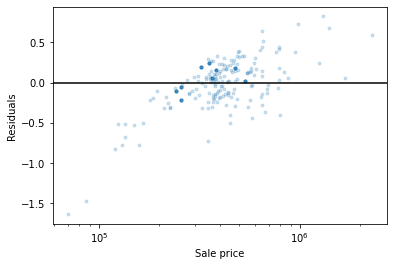

In [16]:
plt.semilogx(df["prices"], model_log.resid, ".", alpha=0.2)
plt.ylabel("Residuals")
plt.xlabel("Sale price")
plt.axhline(0, color="black")

The cluster in the bottom left corner shows properties that sold at a much lower price than expected by the model, which can be explained as transactions below market rate. Lets check if the cheapest houses contain more of this outliers

In [21]:
prices0=df['prices']
prices0.sort_values()

37       70000.0
68       86000.0
75      120000.0
67      125000.0
93      129900.0
         ...    
109    1250000.0
41     1300000.0
53     1395000.0
183    1685000.0
73     2295000.0
Name: prices, Length: 227, dtype: float64

Lets look at the second cheapest

In [22]:
print("predicted sale price: ${:.0f}".format(
        np.exp(model_log.fittedvalues.iloc[68]))+'\n')
print('Outlier details: {}'.format(df.iloc[68]))

predicted sale price: $374329

Outlier details: prices                                       86000.0
address     16813 N 1st Ln SPACE 6 Phoenix AZ 85023 
beds                                               3
zipcode                                            0
lat                                              0.0
long                                             0.0
url                                                0
baths                                              2
sq_feet                                         1536
Name: 68, dtype: object


It would be reasonable to get rip of those two outliers

In [23]:
df=df.drop(labels=[37,68],axis=0)

Lets see how things improve

In [24]:
model_log = smf.ols(formula = "np.log(prices) ~ beds + baths+  sq_feet", 
                 data = df).fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.log(prices)   R-squared:                       0.652
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     138.1
Date:                Wed, 24 Nov 2021   Prob (F-statistic):           2.05e-50
Time:                        12:52:38   Log-Likelihood:                -10.524
No. Observations:                 225   AIC:                             29.05
Df Residuals:                     221   BIC:                             42.71
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.0034      0.071    169.903      0.000      11.864      12.143
beds           0.1063      0.033      3.232      0.001       0.041       0.171
baths         -0.0619      0.035     -1.757      0.080      -0.131       0.008
sq_feet        0.0004      5e-05      8.474      0.000       0.000       0.001
==============================================================================
Omnibus:                       11.787   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               19.510
Skew:                          -0.287   Prob(JB):                     5.80e-05
Kurtosis:                       4.323   Cond. No.                     8.06e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

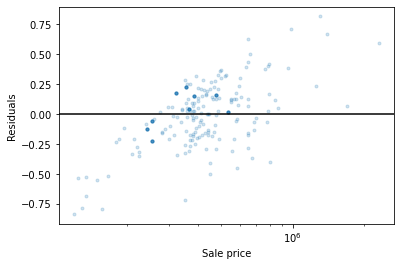

In [25]:
plt.semilogx(df["prices"], model_log.resid, ".", alpha=0.2)
plt.ylabel("Residuals")
plt.xlabel("Sale price")
plt.axhline(0, color="black")

Now we can see that R improve and the statistical significance of ''baths' also improves. We also see that the the residual are much better distributed

In [26]:
iworst = np.abs(model_log.resid.values).argmax()
print('Max. residual position: {0}'.format(iworst) )
print("predicted sale price: ${:.0f}".format(
        np.exp(model_log.fittedvalues.iloc[iworst]))+'\n')
print('Outlier details: {}'.format(df.iloc[iworst])) # select the worst row

Max. residual position: 65
predicted sale price: $378861

Outlier details: prices                                              369900.0
address                4831 N Limonero Cir Phoenix AZ 85037 
beds                                                       3
zipcode                                                85308
lat                                                33.649954
long                                             -112.157202
url        https://www.zillow.com/homedetails/18036-N-45t...
baths                                                      2
sq_feet                                                 1416
Name: 69, dtype: object


In [25]:
df=df.drop(labels=65,axis=0)

In [22]:
model_log = smf.ols(formula = "np.log(prices) ~ beds + baths+  sq_feet", 
                 data = df).fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         np.log(prices)   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     117.2
Date:                Wed, 24 Nov 2021   Prob (F-statistic):           2.22e-45
Time:                        12:30:48   Log-Likelihood:                -24.896
No. Observations:                 224   AIC:                             57.79
Df Residuals:                     220   BIC:                             71.44
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.0163      0.076    157.083      0.000      11.865      12.167
beds           0.0973      0.035      2.744      0.007       0.027       0.167
baths         -0.0608      0.038     -1.614      0.108      -0.135       0.013
sq_feet        0.0004   5.34e-05      8.025      0.000       0.000       0.001
==============================================================================
Omnibus:                       53.912   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              207.116
Skew:                          -0.910   Prob(JB):                     1.06e-45
Kurtosis:                       7.345   Cond. No.                     8.17e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

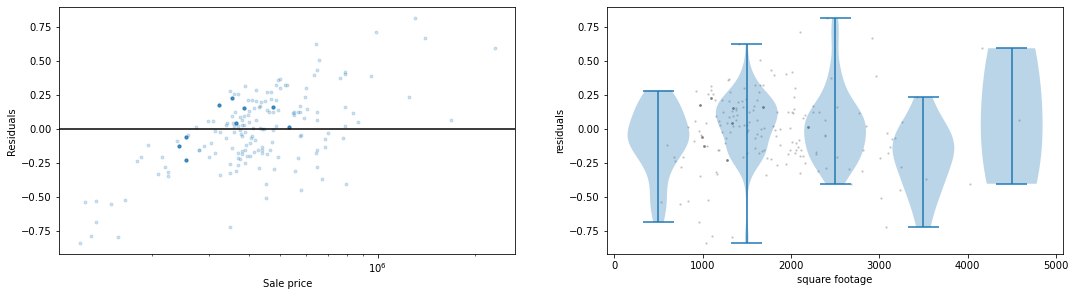

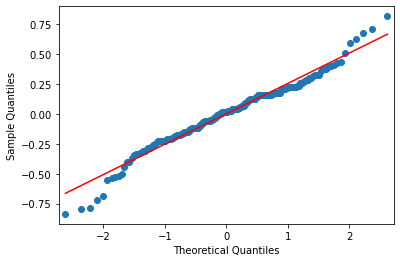

In [36]:
plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
plt.semilogx(df["prices"], model_log.resid, ".", alpha=0.2)
plt.ylabel("Residuals")
plt.xlabel("Sale price")
plt.axhline(0, color="black");

plt.subplot(2,2,2)
plt.scatter(df['sq_feet'], model_log.resid, s=2, alpha=0.3, color="grey")
# violin plot of the same data, divided into 5 bins:
bins = np.array([0, 1000, 2000, 3000, 4000])
sqft_bin = np.digitize(df['sq_feet'], bins)
plt.violinplot([model_log.resid.values[sqft_bin == ibin] for ibin in range(1,len(bins)+1)],
               positions=[500, 1500, 2500, 3500, 4500],
               widths=700,
               showextrema=True,
               )
plt.xlabel("square footage")
plt.ylabel("residuals")

plt.subplot(2,2,2)
sm.qqplot(model_log.resid, line="s");


### How can my choice house will cost in phoenix?

In [46]:
# formula = "np.log(prices) ~ beds + baths+  sq_feet"
np.exp(model_log.predict(exog=dict(beds=2,baths=1,sq_feet=900)))

0    277993.43089
dtype: float64

## Using the public datasets from Zillow
https://www.zillow.com/research/data/

In [14]:
df_1=pd.read_csv('Metro_mlp_uc_sfrcondo_sm_month.csv')  
display(df_1.head())

,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31
0,102001,0,United States,Country,NaN,271600.0,272967.0,279333.0,288667.0,295633.0,...,333533.0,333850.0,340362.0,353728.0,367045.0,378267.0,381567.0,379933.0,376633.0,375000.0
1,394913,1,"New York, NY",Msa,NY,517967.0,523000.0,534333.0,544667.0,554666.0,...,661666.0,668000.0,673000.0,675000.0,675000.0,666667.0,658000.0,643200.0,636533.0,631867.0
2,753899,2,"Los Angeles-Long Beach-Anaheim, CA",Msa,CA,798333.0,802667.0,818000.0,835000.0,848300.0,...,996997.0,998698.0,1005698.0,1006364.0,1006666.0,999666.0,991333.0,971333.0,946667.0,931633.0
3,394463,3,"Chicago, IL",Msa,IL,301000.0,305967.0,319300.0,335967.0,345967.0,...,331333.0,331667.0,338300.0,346633.0,352967.0,354667.0,354633.0,348267.0,339933.0,332967.0
4,394514,4,"Dallas-Fort Worth, TX",Msa,TX,341996.0,345330.0,351663.0,359830.0,366163.0,...,350726.0,352141.0,357025.0,365358.0,374884.0,383333.0,390167.0,393500.0,396500.0,397667.0


In [63]:
df_1['RegionName'].unique()

array(['United States', 'New York, NY',
       'Los Angeles-Long Beach-Anaheim, CA', 'Chicago, IL',
       'Dallas-Fort Worth, TX', 'Philadelphia, PA', 'Houston, TX',
       'Washington, DC', 'Miami-Fort Lauderdale, FL', 'Atlanta, GA',
       'Boston, MA', 'San Francisco, CA', 'Detroit, MI', 'Riverside, CA',
       'Phoenix, AZ', 'Seattle, WA', 'Minneapolis-St Paul, MN',
       'San Diego, CA', 'St. Louis, MO', 'Tampa, FL', 'Baltimore, MD',
       'Denver, CO', 'Pittsburgh, PA', 'Portland, OR', 'Charlotte, NC',
       'Sacramento, CA', 'San Antonio, TX', 'Orlando, FL',
       'Cincinnati, OH', 'Cleveland, OH', 'Kansas City, MO',
       'Las Vegas, NV', 'Columbus, OH', 'Indianapolis, IN',
       'San Jose, CA', 'Austin, TX', 'Virginia Beach, VA',
       'Nashville, TN', 'Providence, RI', 'Milwaukee, WI',
       'Jacksonville, FL', 'Memphis, TN', 'Oklahoma City, OK',
       'Louisville-Jefferson County, KY', 'Hartford, CT', 'Richmond, VA',
       'New Orleans, LA', 'Buffalo, NY', 'Raleig

In [66]:
df_phx_med=df_1[df_1['RegionName']=='Phoenix, AZ']
df_phx_med

,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31
14,394976,14,"Phoenix, AZ",Msa,AZ,339143.0,345091.0,353451.0,358855.0,361744.0,...,408382.0,409276.0,415000.0,424667.0,438000.0,449667.0,459967.0,466633.0,471600.0,474933.0


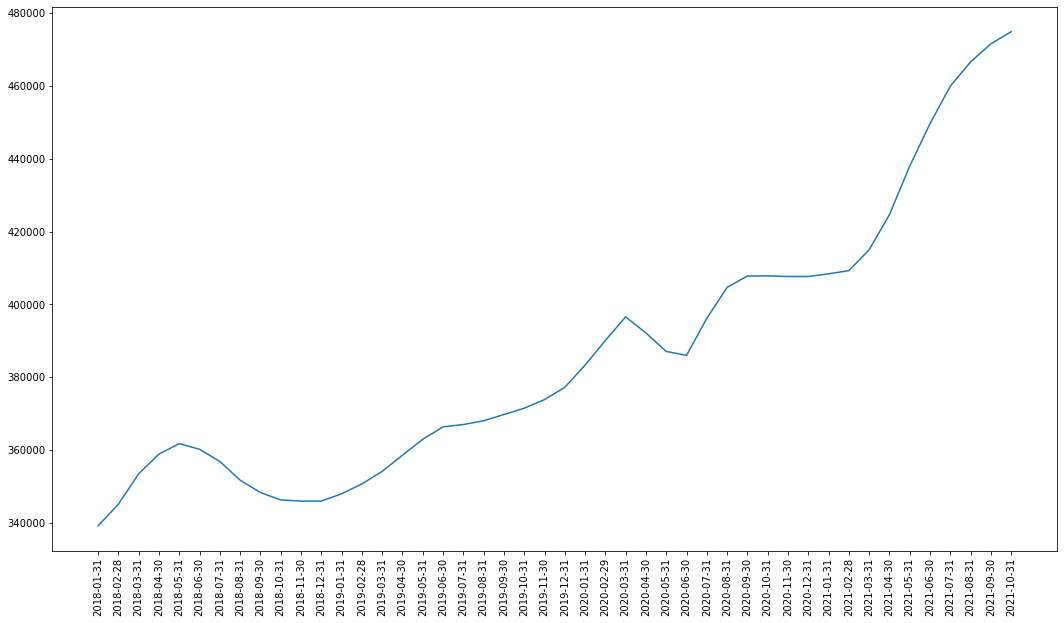

In [75]:
#df_phx_med_table=df_phx_med.iloc[0]
plt.figure(figsize=(18,10))
plt.plot(df_phx_med.iloc[0][5:])
plt.xticks(rotation = 90) 
plt.show()

Lets compare with a more or less already consolidate market, like, say NYC

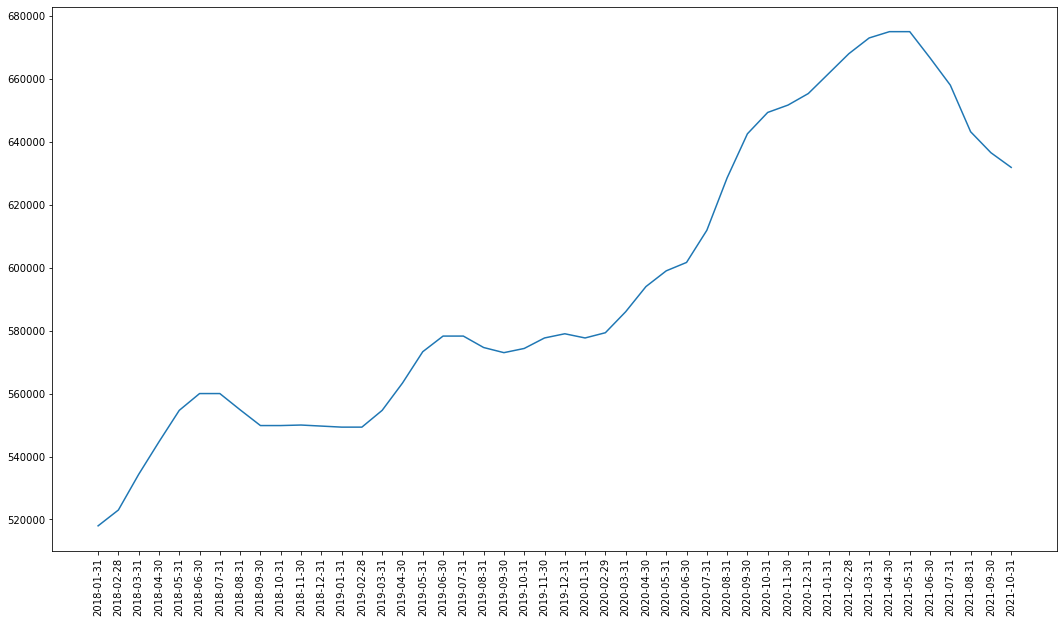

In [77]:
df_nyc_med=df_1[df_1['RegionName']=='New York, NY']

#df_phx_med_table=df_phx_med.iloc[0]
plt.figure(figsize=(18,10))
plt.plot(df_nyc_med.iloc[0][5:])
plt.xticks(rotation = 90) 
plt.show()

In [104]:
states=df_1['RegionName'].unique()
states=np.delete(states,0)
states

array(['New York, NY', 'Los Angeles-Long Beach-Anaheim, CA',
       'Chicago, IL', 'Dallas-Fort Worth, TX', 'Philadelphia, PA',
       'Houston, TX', 'Washington, DC', 'Miami-Fort Lauderdale, FL',
       'Atlanta, GA', 'Boston, MA', 'San Francisco, CA', 'Detroit, MI',
       'Riverside, CA', 'Phoenix, AZ', 'Seattle, WA',
       'Minneapolis-St Paul, MN', 'San Diego, CA', 'St. Louis, MO',
       'Tampa, FL', 'Baltimore, MD', 'Denver, CO', 'Pittsburgh, PA',
       'Portland, OR', 'Charlotte, NC', 'Sacramento, CA',
       'San Antonio, TX', 'Orlando, FL', 'Cincinnati, OH',
       'Cleveland, OH', 'Kansas City, MO', 'Las Vegas, NV',
       'Columbus, OH', 'Indianapolis, IN', 'San Jose, CA', 'Austin, TX',
       'Virginia Beach, VA', 'Nashville, TN', 'Providence, RI',
       'Milwaukee, WI', 'Jacksonville, FL', 'Memphis, TN',
       'Oklahoma City, OK', 'Louisville-Jefferson County, KY',
       'Hartford, CT', 'Richmond, VA', 'New Orleans, LA', 'Buffalo, NY',
       'Raleigh, NC', 'Birmingh

States with houses average cost greater than $600000

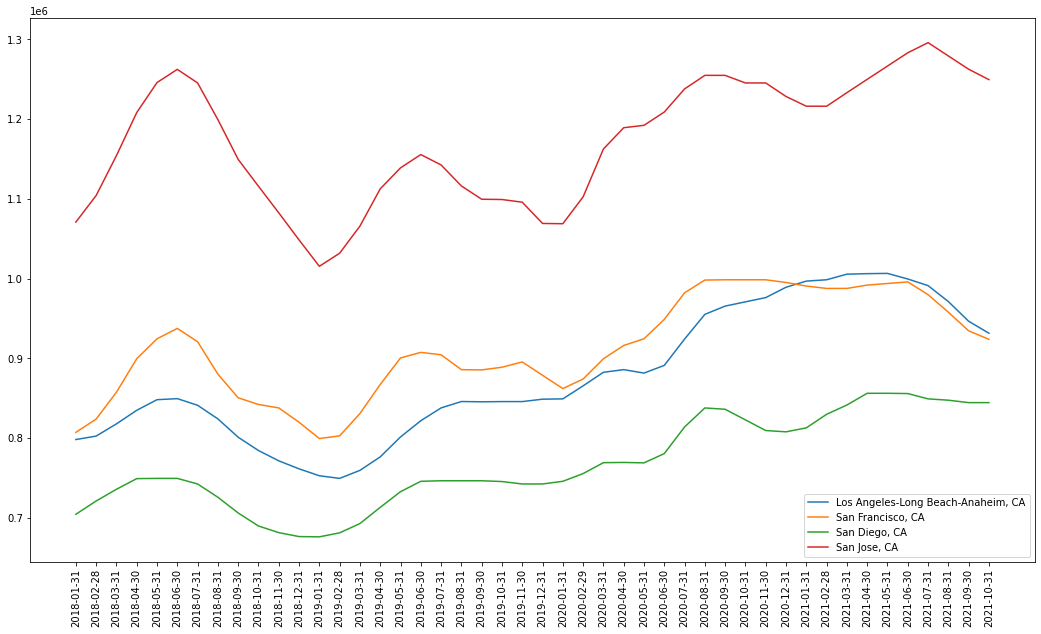

In [120]:
plt.figure(figsize=(18,10))
for state in states:
    if df_1[df_1['RegionName']==state]['2021-10-31'].iloc[0]>700000:
        df=df_1[df_1['RegionName']==state]
        plt.plot(df.iloc[0][5:],label=state)
plt.xticks(rotation = 90) 
plt.legend(loc='best')
plt.show()

States with houses average cost between 500000 and 600000

States with houses averages between  150000 and 200000


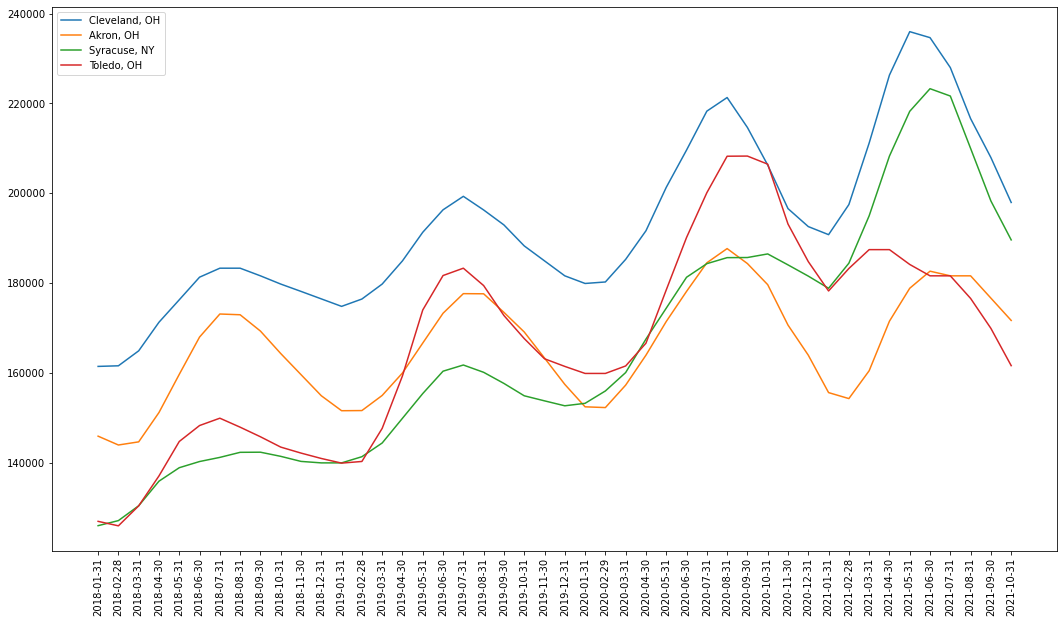

States with houses averages between  200000 and 250000


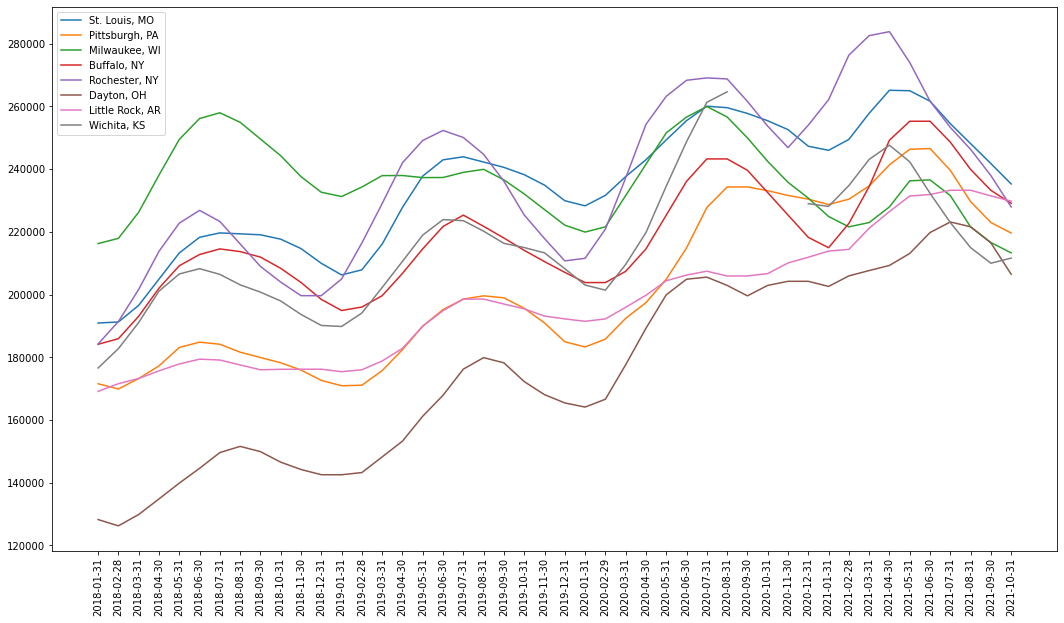

States with houses averages between  250000 and 300000


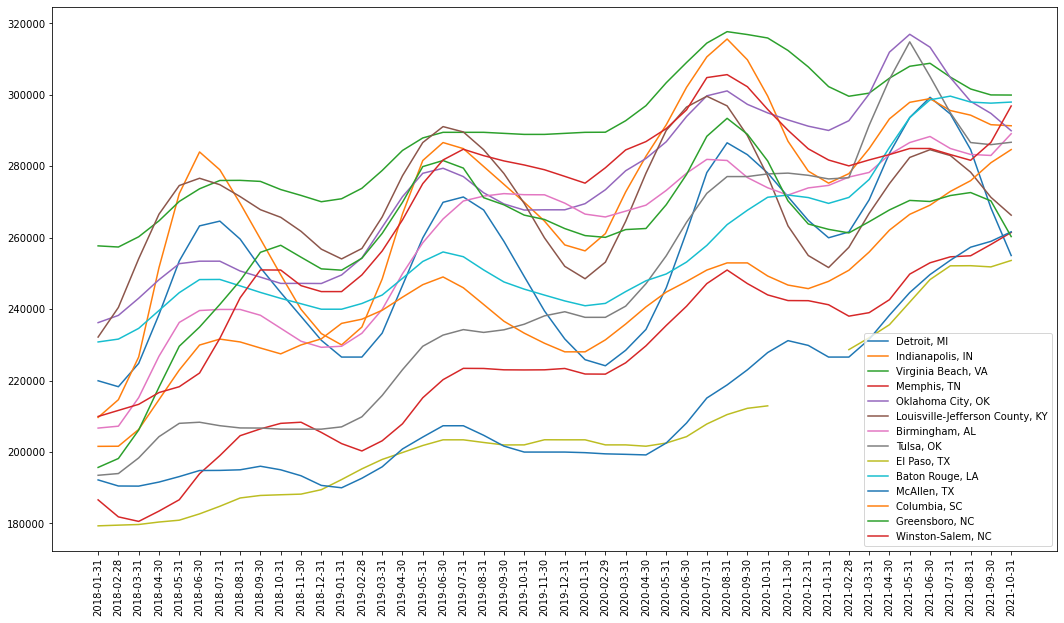

States with houses averages between  300000 and 350000


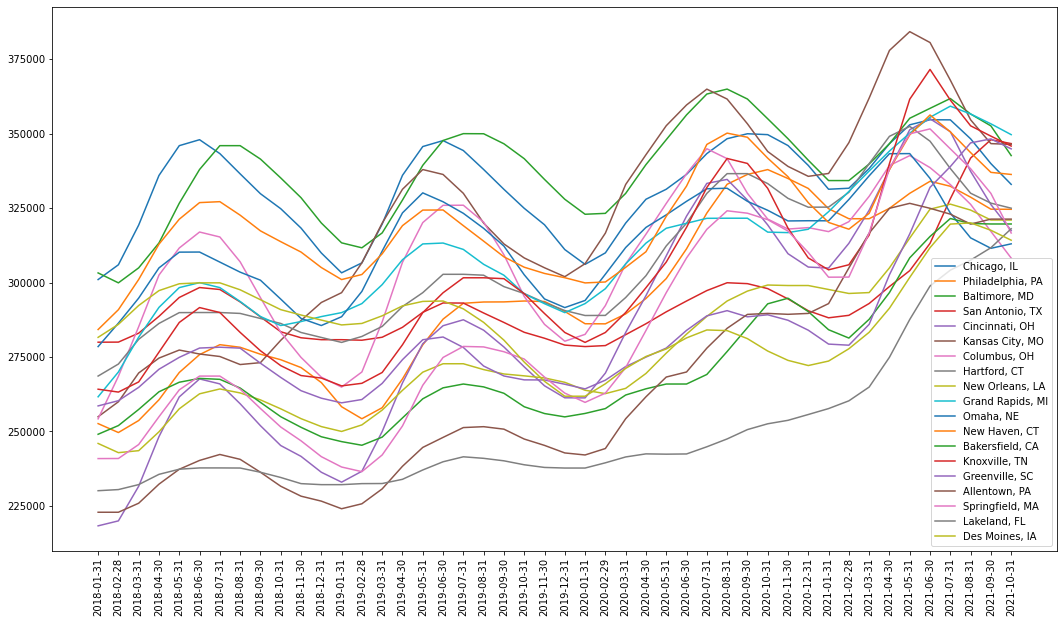

States with houses averages between  350000 and 400000


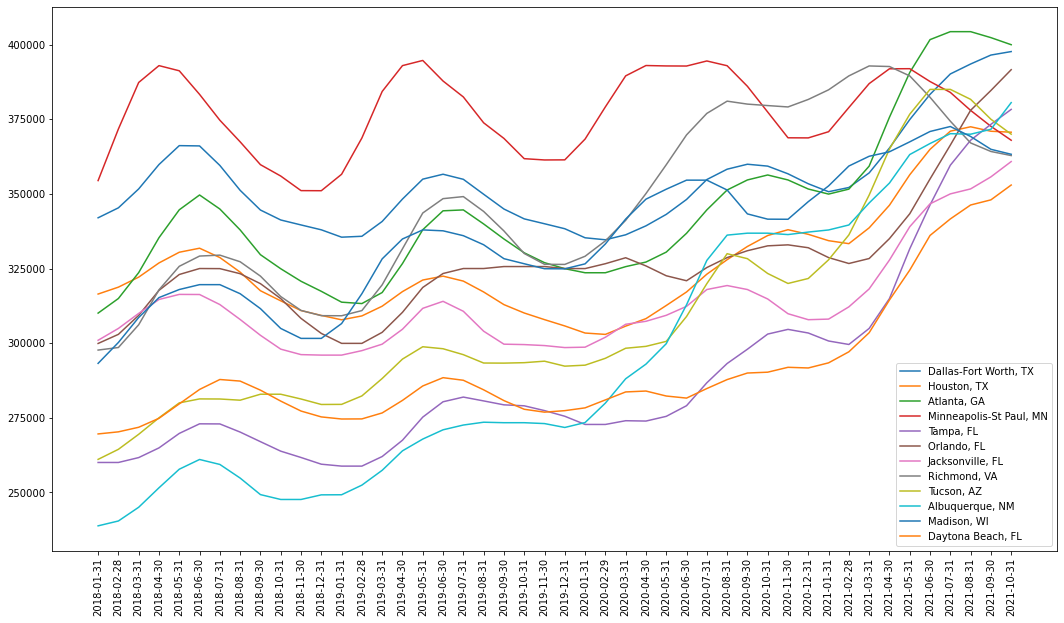

States with houses averages between  400000 and 450000


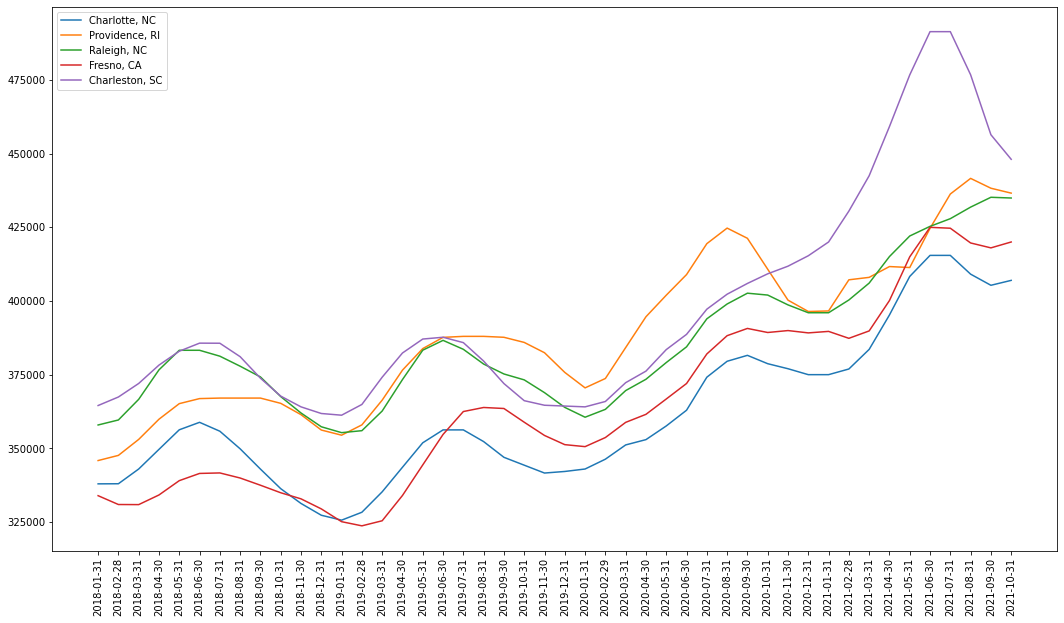

States with houses averages between  450000 and 500000


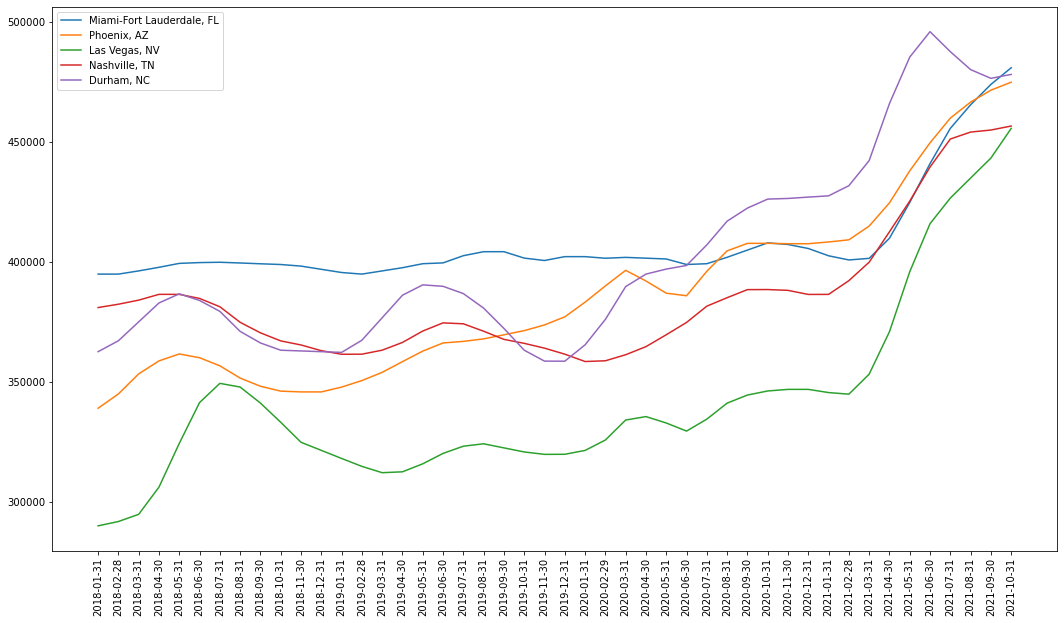

States with houses averages between  500000 and 550000


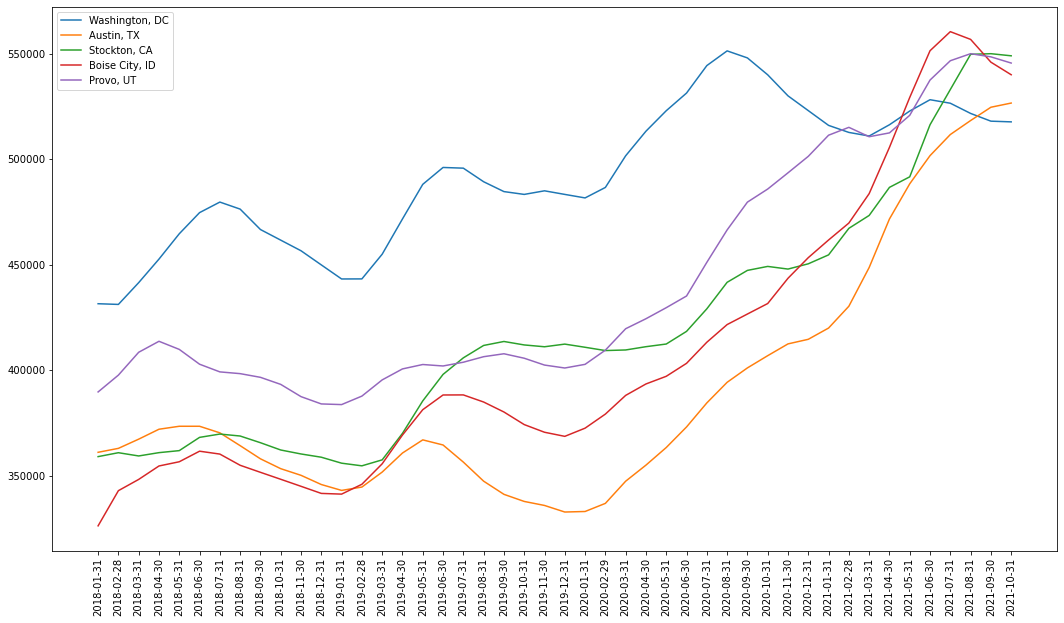

States with houses averages between  550000 and 600000


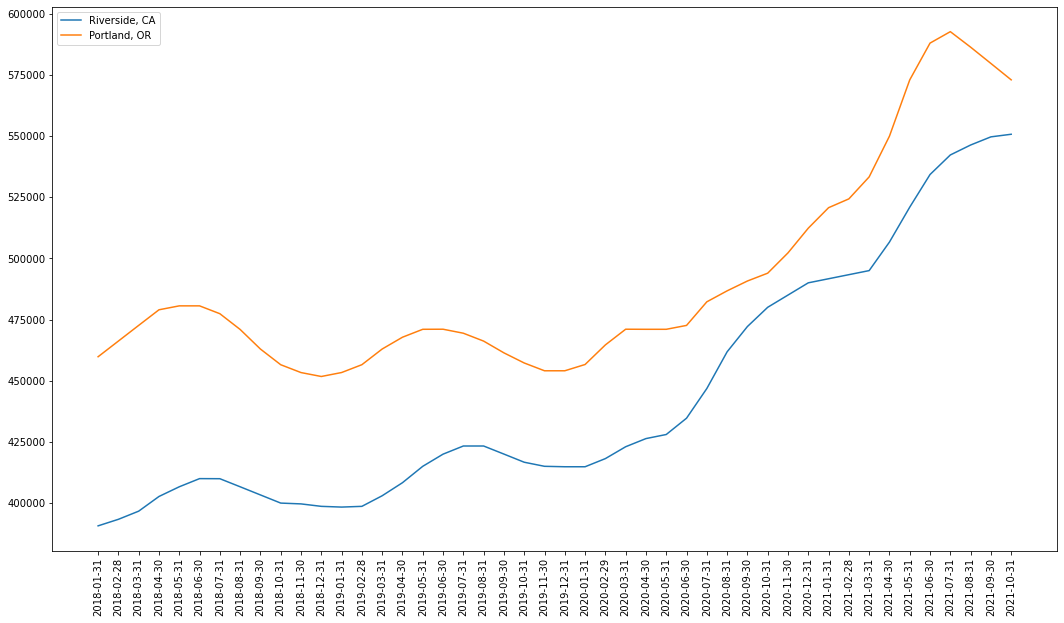

States with houses averages between  600000 and 650000


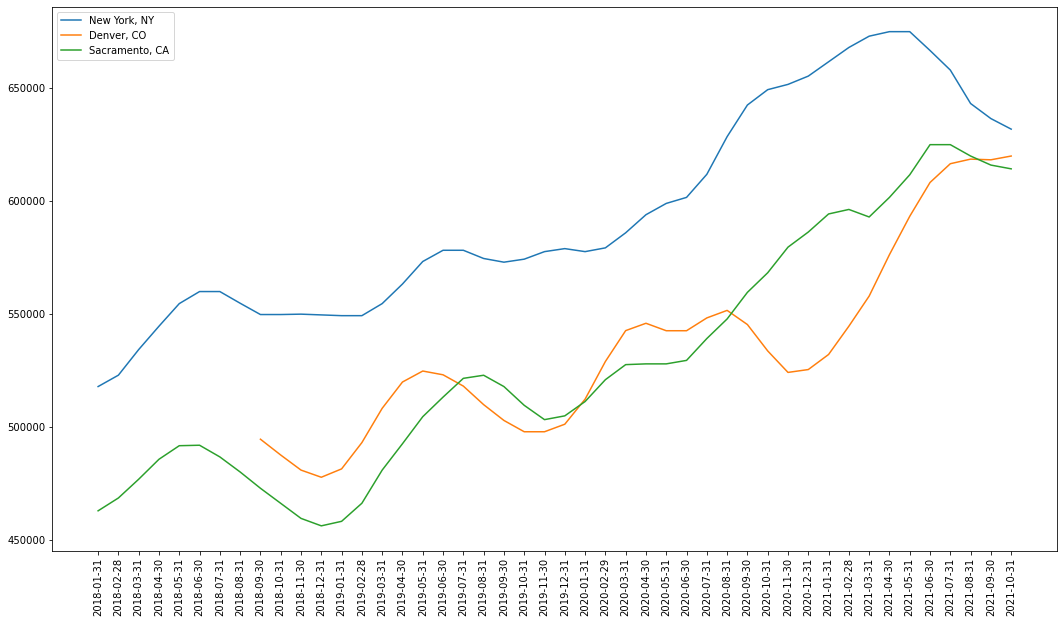

States with houses averages between  650000 and 700000


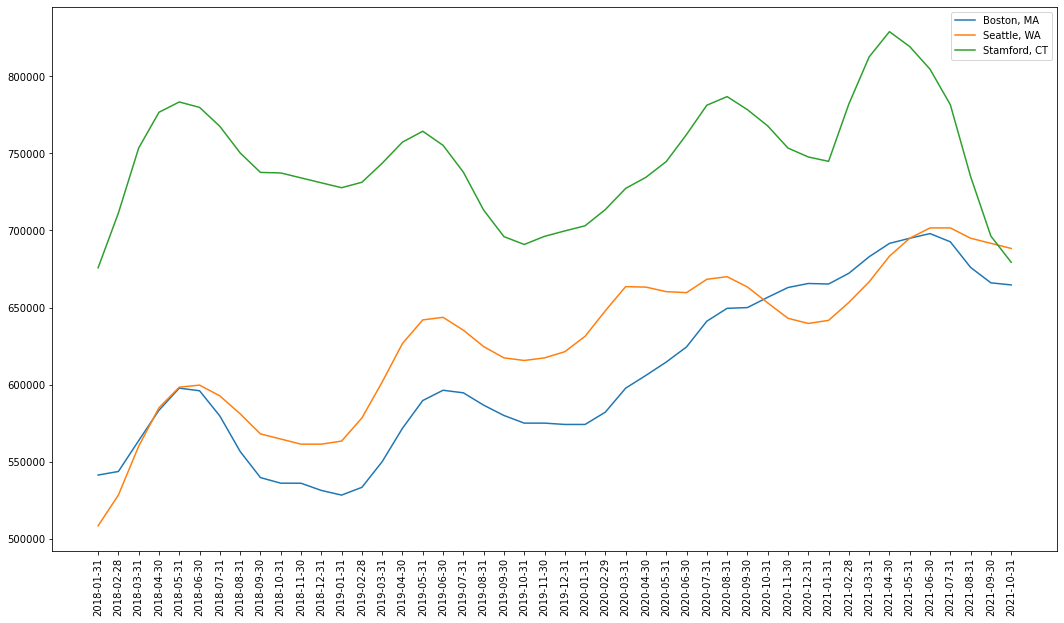

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


States with houses averages between  700000 and 750000


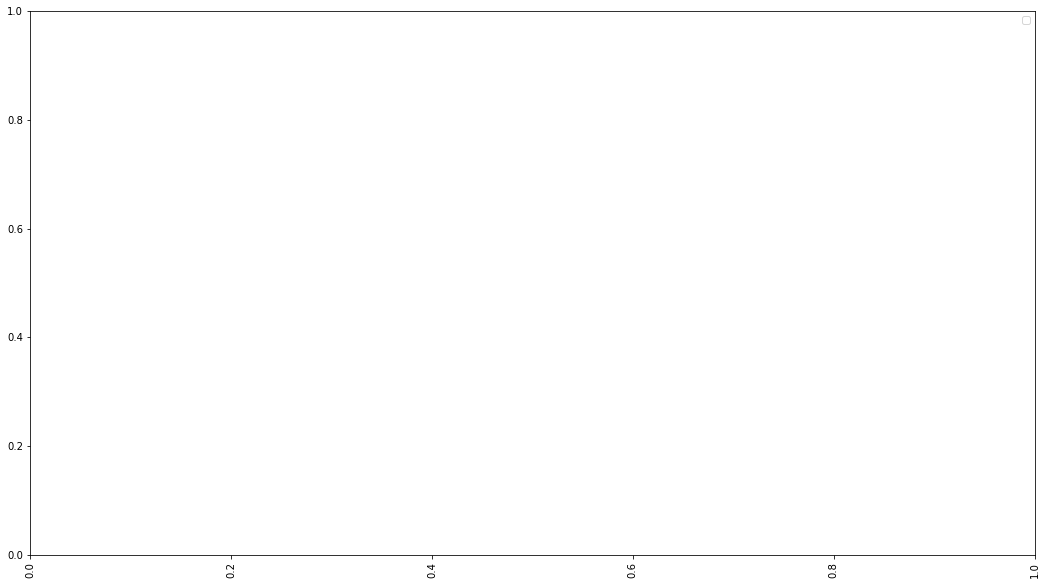

In [125]:
for i in range(3,14):
    cost_below=i*50000
    cost_above=(i+1)*50000
    plt.figure(figsize=(18,10))
    print('States with houses averages between  {} and {}'.format(cost_below, cost_above))
    for state in states:
        if df_1[df_1['RegionName']==state]['2021-10-31'].iloc[0]>cost_below and df_1[df_1['RegionName']==state]['2021-10-31'].iloc[0]<cost_above :
            df=df_1[df_1['RegionName']==state]
            plt.plot(df.iloc[0][5:],label=state)
    plt.xticks(rotation = 90) 
    plt.legend(loc='best')
    plt.savefig('States with houses averages between  {} and {}'.format(cost_below, cost_above))
    plt.show()